# Purpose: 
Generate a fire perimeter in GeoJSON based on the input pre and post flight images

In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/uavsar-main/python").resolve()
sys.path.append(str(utils_path))

import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.plot import show
# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from process_utils import (preprocess_data, 
                           superpixel_segmentation,
                           get_superpixel_model_labels,get_model_labels,
                           convert_labels_to_gdf,
                           filter_by_area,
                           merge_geojson,
                           tv_denoise,)
from nd_utils import (get_superpixel_means_as_features,
                      get_superpixel_stds_as_features,get_superpixel_medians_as_features,
                      get_array_from_features)
# # from process_utils import (preprocess_data, 
#                            get_model_labels)
from rio_utils import (reproject_arr_to_match_profile)
from shapely.geometry import Polygon
from shapely.geometry import Point
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [2]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the preprocessed images
- `superpixel_labels_list` (list): a list containing the paths to the superpixel labels

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
        transform = ds.transform
    return band, profile, transform

In [4]:
# Path to the folder with the preprocessed images
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio")

tifs = sorted(list(data_dir.glob('./*before_imputed_*.tif')))
tifs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio/before_imputed_hv_0_preprocessed_interpolated.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio/before_imputed_hv_1_preprocessed_interpolated.tif')]

---
Open the preprocessed images and load the superpixel segmentation corresponded to the pre- and post- fire.

- Let `hv_0` correspond to the pre-fire image and `hv_1` correspond to the post-fire image. 
- Let `profile` and `transform` correspond to the pre-fire image.
- Let `superpixel_labels` be the output of the segmentation

In [5]:
# open the tifs
bands_tv, profiles, transforms = zip(*map(open_one, tifs))
hv_0 = bands_tv[0]
hv_1 = bands_tv[1]
profile = profiles[0]
transform = transforms[0]

In [6]:
hv_0 = denoise(hv_0,5)
hv_1 = denoise(hv_1,5)

---
This is the preprocessed raster image we will work with to extract the fire perimeter

In [7]:
# compute log ratio and filter out the vegetation gain by setting to no change.
log_ratio = 10*np.log10(hv_0/hv_1)

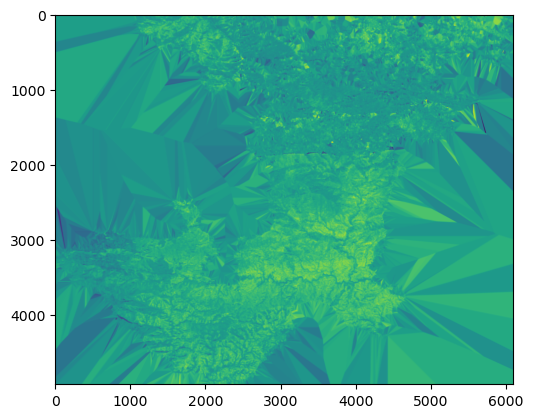

In [8]:
plt.imshow(log_ratio)

In [9]:
# Load if we have performed segmentation previously
superpixel_labels = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio/superpixel_labels_test_230727_231017_min1000.npy")

In [10]:
print("superpizel_labels: ")
print(superpixel_labels)

superpizel_labels: 
[[   0    0    0 ...   95   95   95]
 [   0    0    0 ...   95   95   95]
 [   0    0    0 ...   95   95   95]
 ...
 [4478 4288 4288 ... 4552 4552 4552]
 [4478 4288 4288 ... 4552 4552 4552]
 [4478 4288 4288 ... 4552 4552 4552]]


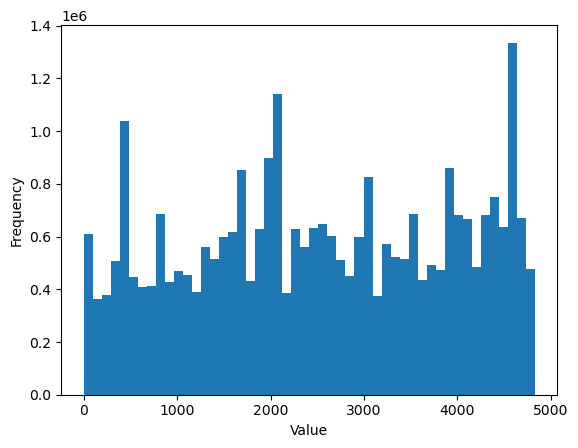

In [11]:
# Check the distribution of the data
plt.hist(superpixel_labels.flatten(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Classification

In [12]:
pre_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/pre_merged_alpha1_image_test_before_imputed.npy")
post_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/post_merged_alpha_image_test_aligned_before_imputed.npy")
slope = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Slope/slope_aligned.npy")

In [13]:
print("pre_alpha1", pre_alpha1.shape)

pre_alpha1 (4921, 6093)


In [14]:
print("post_alpha1", post_alpha1.shape)

post_alpha1 (4921, 6093)


In [15]:
print("slope", slope.shape)

slope (4921, 6093)


In [16]:
np.seterr(divide='ignore', invalid='ignore')
#Extracting features
mean_log_ratio = get_superpixel_means_as_features(superpixel_labels, log_ratio)
median_pre_alpha1 = get_superpixel_medians_as_features(superpixel_labels, pre_alpha1)
median_post_alpha1 = get_superpixel_medians_as_features(superpixel_labels, post_alpha1)
diff_alpha1 = median_pre_alpha1 - median_post_alpha1
median_slope = get_superpixel_medians_as_features(superpixel_labels, slope)
# mean_slope = get_superpixel_means_as_features(superpixel_labels, slope)


In [17]:
unique_superpixel_labels = np.unique(superpixel_labels)
unique_superpixel_labels_reshape = unique_superpixel_labels.reshape(-1,1)


In [18]:
print(unique_superpixel_labels_reshape.shape)

(4832, 1)


In [19]:
# I need to check how to make a dataframe using these columns
fire_data = np.hstack([unique_superpixel_labels_reshape, diff_alpha1])

In [20]:
# # I need to check how to make a dataframe using these columns
# fire_data = np.hstack([unique_superpixel_labels_reshape,mean_log_ratio, diff_alpha1, median_slope])

In [21]:
import pandas as pd
# Create pandas dataframe with column names
df = pd.DataFrame(fire_data, columns=['superpixel_label', 'diff_alpha1'])
print(df)

      superpixel_label  diff_alpha1
0                  0.0          NaN
1                  1.0          NaN
2                  2.0          NaN
3                  3.0          NaN
4                  4.0     5.203716
...                ...          ...
4827            4827.0          NaN
4828            4828.0          NaN
4829            4829.0          NaN
4830            4830.0          NaN
4831            4831.0          NaN

[4832 rows x 2 columns]


In [22]:
# Calculate the number of non-null values in each row
non_null_counts = df.count(axis=1)

# Get the total number of columns
num_columns = df.shape[1]

# Determine complete rows
complete_rows = df[non_null_counts == num_columns]

# Count the number of complete rows
num_complete_rows = len(complete_rows)
print(num_complete_rows)

1935


In [23]:
# retain only complete rows
df_cleaned = df.dropna()
print(len(df_cleaned))
#pd.set_option('display.max_rows',None)
print(df_cleaned)

1935
      superpixel_label  diff_alpha1
4                  4.0     5.203716
5                  5.0     2.616558
6                  6.0     4.063989
7                  7.0     5.294187
8                  8.0     5.856016
...                ...          ...
4775            4775.0     4.019243
4784            4784.0    11.319916
4790            4790.0    11.671707
4792            4792.0     5.992162
4797            4797.0    11.903642

[1935 rows x 2 columns]


In [24]:
df_cleaned_for_model = df_cleaned.drop('superpixel_label', axis=1) # we don't want to use the superpixel label as a feature
print(df_cleaned_for_model)

      diff_alpha1
4        5.203716
5        2.616558
6        4.063989
7        5.294187
8        5.856016
...           ...
4775     4.019243
4784    11.319916
4790    11.671707
4792     5.992162
4797    11.903642

[1935 rows x 1 columns]


Other Hyperparameter Values for K-means

In [25]:
from sklearn.cluster import KMeans

model = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=1e-4,
    algorithm='elkan',
    random_state=42
)
classes = get_superpixel_model_labels(df_cleaned_for_model, model)
classes = classes + 1
classes

array([4, 2, 2, ..., 1, 4, 1], dtype=int32)

In [26]:
print(np.unique(classes))

[1 2 3 4]


In [27]:
# print(len(classes))

print(df_cleaned.shape)

(1935, 2)


In [28]:
# Dr.Uma Code
model_output = superpixel_labels
# model_output = np.empty_like(superpixel_labels)
# model_output[:] = 0 # 0 indicates missing values since classes are numbered 1, 2, ...

for i in range(len(classes)):
    # print(i)
    # print(df_cleaned.iat[i,0])
    # print(classes[i])
    model_output[model_output==int(df_cleaned.iat[i,0])] = classes[i]
    # model_output = np.where(model_output == int(df_cleaned.iat[i,0]),classes[i],0) # logically this is correct
    # np.put(model_output,np.where(model_output==int(df_cleaned.iat[i,0])),classes[i])
    # model_output.replace(df_cleaned.iat[i,0],classes[i])
# print(superpixel_labels)
# print(model_output)

In [29]:
print(model_output)

[[   0    0    0 ...   95   95   95]
 [   0    0    0 ...   95   95   95]
 [   0    0    0 ...   95   95   95]
 ...
 [4478 4288 4288 ... 4552 4552 4552]
 [4478 4288 4288 ... 4552 4552 4552]
 [4478 4288 4288 ... 4552 4552 4552]]


In [30]:
#print(np.unique(model_output))
print(type(model_output))

<class 'numpy.ndarray'>


In [ ]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
colors = ['lightgray'] * 10  # A default color for other values
colors[1] = '#fefa07' 
colors[2] = '#036201' 
colors[3] = '#80face'
colors[4] = '#fc0200'
# Unburned to Low: HEX #036201
# Low: #80face
# Moderate: #fefa07
# High: #fc0200
class_names = {
    1: "Moderate",
    2: "Unburned",
    3: "Low",
    4: "High"
}

cmap = mcolors.ListedColormap(colors)

bounds = np.arange(len(colors) + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

legend_patches = [
    mpatches.Patch(color=colors[i], label=class_names[i]) for i in class_names
 ]

plt.imshow(model_output, cmap=cmap, norm=norm)
# plt.colorbar(ticks=np.arange(len(colors))) # Add a colorbar for reference
plt.title('BurnSeverity Classification superpixel_1000')
# plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.show()